# Policy-based agent in the cart-pole environment using PyTorch

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [1]:
import sys
import time
import torch
import gymnasium as gym
import matplotlib.pyplot as plt

from REINFORCE import PolicyGradient

sys.path.append("../")
from help.visualisation.plot import plot                                                    # noqa
from help.visualisation.gif import gif2                                                     # noqa

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

### Training

#### Parameters

In [3]:
GAMES = 5000

NETWORK = {"inputs": 4, "outputs": 2, "nodes": [30, 15]}
OPTIMIZER = {"optimizer": torch.optim.RMSprop, "lr": 0.00025}

#### Initialisation

In [4]:
policy_agent = PolicyGradient(
    network=NETWORK, optimizer=OPTIMIZER
)

checkpoint = GAMES // 10
metrics = {metric: torch.zeros(GAMES) for metric in ["steps", "gradients"]}

#### Training

In [5]:
start = time.time()
for game in range(1, GAMES + 1):
    
    state = torch.tensor(environment.reset()[0], dtype=torch.float32).view(-1)
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action, logarithm = policy_agent.action(state)
        state, reward, terminated, truncated, _ = environment.step(action)
        state = torch.tensor(state, dtype=torch.float32).view(-1)
        policy_agent.memorize(logarithm, reward)
    gradient = policy_agent.learn()
    
    # METRICS
    # ----------------------------------------------------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["gradients"][game-1] = gradient
    
    if game % checkpoint == 0 or game == GAMES:

        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_gradient = metrics["gradients"][max(0, game-checkpoint-1):game-1].mean()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average gradients: {_mean_gradient:>8.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game    500               10 % 
------------------------------ 
 > Average steps:           24 
 > Average gradients:  -0.0955 
 
Game   1000               20 % 
------------------------------ 
 > Average steps:           33 
 > Average gradients:  -0.3658 
 
Game   1500               30 % 
------------------------------ 
 > Average steps:           53 
 > Average gradients:  -0.7645 
 
Game   2000               40 % 
------------------------------ 
 > Average steps:          110 
 > Average gradients:  -1.7833 
 
Game   2500               50 % 
------------------------------ 
 > Average steps:          204 
 > Average gradients:  -2.8025 
 
Game   3000               60 % 
------------------------------ 
 > Average steps:          292 
 > Average gradients:  -3.5420 
 
Game   3500               70 % 
------------------------------ 
 > Average steps:          351 
 > Average gradients:  -3.6019 
 
Game   4000               80 % 
------------------------------ 
 > Average steps:         

#### Visualisation

##### Metrics

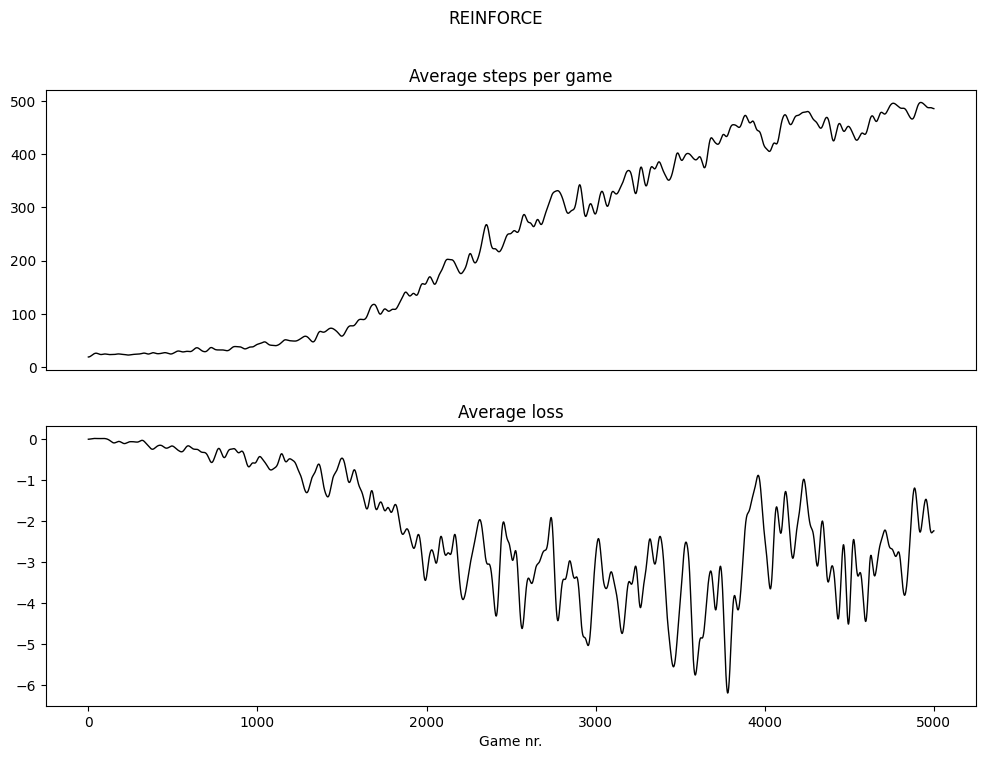

In [10]:
plot(metrics, "REINFORCE", window=15)
plt.savefig("./results/reinforce-cart-pole-metrics.png")
plt.show()

##### In action

In [8]:
gif2(environment, policy_agent, './results/reinforce-cart-pole.gif')

<img src="./results/reinforce-cart-pole.gif" width="1000" height="1000" />

In [9]:
environment.close()